In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import glob

In [2]:
train = pd.read_csv('./train.csv')

train_df = pd.DataFrame(train)

train_df.head()

,id,img_path,artist
0,0,./train/0000.jpg,Diego Velazquez
1,1,./train/0001.jpg,Vincent van Gogh
2,2,./train/0002.jpg,Claude Monet
3,3,./train/0003.jpg,Edgar Degas
4,4,./train/0004.jpg,Hieronymus Bosch


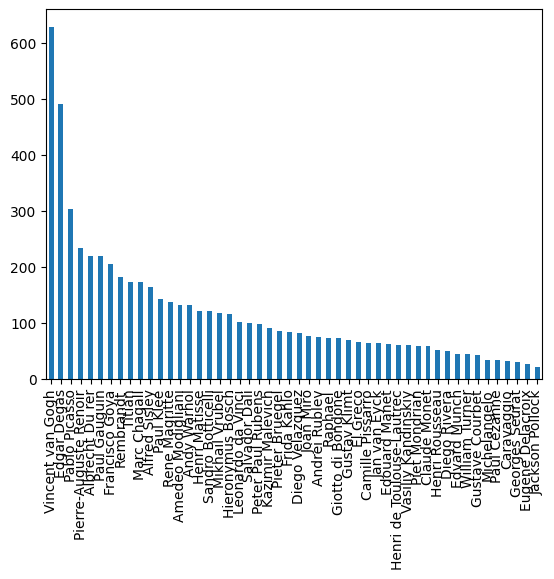

In [3]:
train_df['artist'].value_counts().plot.bar();

In [4]:
train_data, val_data = train_test_split(train_df, test_size = 0.2, stratify = train_df["artist"], random_state = 13)

In [5]:
train_df.count()

id          5911
img_path    5911
artist      5911
dtype: int64

In [6]:
print(len(train_data))
print(len(val_data))

4728
1183


In [7]:
train_df.head()

,id,img_path,artist
0,0,./train/0000.jpg,Diego Velazquez
1,1,./train/0001.jpg,Vincent van Gogh
2,2,./train/0002.jpg,Claude Monet
3,3,./train/0003.jpg,Edgar Degas
4,4,./train/0004.jpg,Hieronymus Bosch


In [8]:
len(train_df['artist'].unique())

50

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True, width_shift_range = 0.1, height_shift_range= 0.1)

train_generator = train_data_gen.flow_from_dataframe(
    dataframe = train_data,
    target_size = (150, 150),
    class_mode = 'categorical',
    x_col = "img_path",
    y_col = "artist", 
)

2022-12-06 20:40:25.152368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 20:40:25.308659: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-06 20:40:25.864500: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.3/lib64
2022-12-06 20:40:25.864568: W tensorflow/compiler/xla/strea

Found 4728 validated image filenames belonging to 50 classes.


In [10]:
val_data_gen = ImageDataGenerator(rescale=1./255)

val_generator = val_data_gen.flow_from_dataframe(
    dataframe = val_data,
    x_col = "img_path",
    y_col = "artist",
    class_mode = "categorical",
    target_size = (150, 150),
    seed = 13,
    shuffle = False
)

Found 1183 validated image filenames belonging to 50 classes.


In [11]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(150, 150, 3), padding = 'same'),
    layers.MaxPooling2D(pool_size = (2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    layers.MaxPooling2D(pool_size = (2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(512, activation = 'relu'),
    layers.Dropout(0.25),
    layers.Dense(50, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 64)        0

2022-12-06 20:40:26.494033: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 20:40:26.499745: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 20:40:26.500246: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 20:40:26.500781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
hist = model.fit(train_generator, epochs = 40, validation_data=val_generator)

Epoch 1/40


2022-12-06 20:40:29.082168: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2022-12-06 20:40:30.845227: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201
2022-12-06 20:40:34.217279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-06 20:40:34.219835: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fb524011d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-06 20:40:34.219855: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2022-12-06 20:40:34.226542: I tensorflow/compiler/mlir/tensorflow/utils/du

148/148 [==============================] - 59s 342ms/step - loss: 3.7156 - accuracy: 0.1030 - val_loss: 3.4909 - val_accuracy: 0.1615
Epoch 2/40
148/148 [==============================] - 37s 251ms/step - loss: 3.3980 - accuracy: 0.1442 - val_loss: 3.2551 - val_accuracy: 0.1623
Epoch 3/40
148/148 [==============================] - 35s 238ms/step - loss: 3.2034 - accuracy: 0.1743 - val_loss: 3.1234 - val_accuracy: 0.2071
Epoch 4/40
148/148 [==============================] - 35s 235ms/step - loss: 3.0372 - accuracy: 0.2119 - val_loss: 3.0761 - val_accuracy: 0.2299
Epoch 5/40
148/148 [==============================] - 35s 234ms/step - loss: 2.9193 - accuracy: 0.2297 - val_loss: 2.9733 - val_accuracy: 0.2325
Epoch 6/40
148/148 [==============================] - 35s 235ms/step - loss: 2.8322 - accuracy: 0.2525 - val_loss: 2.8359 - val_accuracy: 0.2544
Epoch 7/40
148/148 [==============================] - 35s 236ms/step - loss: 2.7025 - accuracy: 0.2805 - val_loss: 2.7512 - val_accuracy: 0.2

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def draw_learning_history(hist, targets, labels, axes_num):
    fig, ax = plt.subplots(1, 2, figsize= (12, 4))

    for i in range(4):
        sns.lineplot(x = range(len(hist.history[targets[i]])),
        y = hist.history[targets[i]], ax = ax[axes_num[i]], label = labels[i])

        ax[0].set_title("Loss"); ax[1].set_title("Accuracy")
        sns.despine(); plt.show()

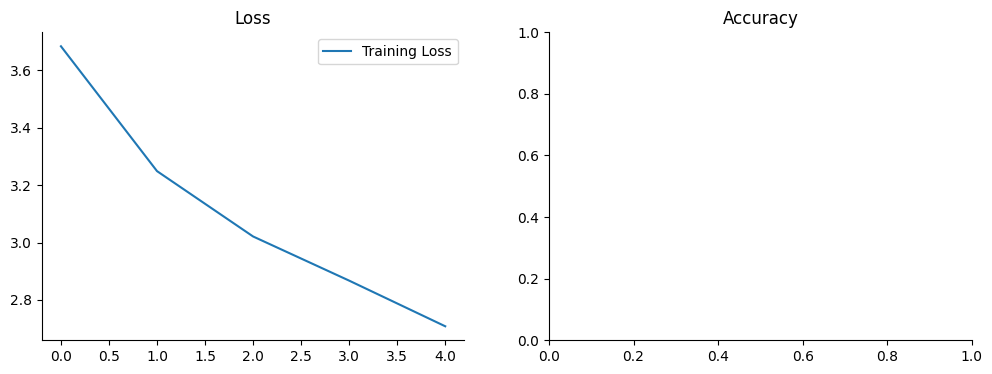

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
targets = ["loss", "val_loss", "accuracy", "val_accuracy"]
labels = ["Training Loss", "Validation Loss", "Training Accuracy", "Validation Accuracy"]
axes_num = [0, 0, 1, 1]

draw_learning_history(hist, targets, labels, axes_num)